# Room Impulse Response
대부분의 오디오 데이터셋은 조용한 공간에서 녹음되었습니다.
그러나 마이크가 어떤 공간에 있느냐에 따라서 입력 오디오의 특징이 조금씩 달라질 수 있습니다.
아래는 다양한 공간의 음향 환경을 무작위로 만들 수 있는 함수입니다. 
출처는 주석으로 표시하였습니다.

In [19]:
# https://github.com/SRPOL-AUI/storir
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import soundfile as sf

In [3]:
# audio_utils

def decibels_to_gain(decibels: float):
    """
    Change unit from decibels to gains.
    Args:
        decibels: value in decibels.

    Returns:
        value in gains.
    """
    return 10 ** (decibels / 20)


def peak_norm(audio: np.ndarray):
    """
    Audio normalisation with respect to highest peak to obtain (-1, 1) amplitudes.
    Args:
        audio: signal to be normalised

    Returns:
        normalised signal
    """
    return audio / np.max(np.abs(audio))

In [4]:
# rir_utils

def calculate_drr_energy_ratio(y, direct_sound_idx):
    """
    Calculates the direct to reverberant sound energy ratio.
    Args:
        y: energetic impulse response
        direct_sound_idx: index of the initial sound ray

    Returns:
        drr energy ratio
    """
    # everything up to the given idx is summed up and treated as direct sound energy
    direct = sum(y[:direct_sound_idx + 1])
    reverberant = sum(y[direct_sound_idx + 1:])
    drr = 10 * np.log10(direct / reverberant)
    return drr


def thin_out_reflections(y, start_idx, end_idx, rate):
    """
    Randomly deletes a fraction of sound rays in a specified time window.
    Args:
        y: energetic impulse response
        start_idx: time window starting sample index
        end_idx: time window ending sample index
        rate: the fraction of sound rays to delete

    Returns:
        energetic IR without fraction of sound rays in specified interval
    """
    ray_indices = [idx for idx in range(start_idx, end_idx + 1) if y[idx] != 0]
    num_rays = int(len(ray_indices) * rate)
    assert num_rays >= 1
    random_subset = np.random.choice(ray_indices, num_rays, replace=False)
    y[random_subset] = 0
    return y

In [5]:
# ir

class ImpulseResponse:

    def __init__(
            self,
            rt60: float,
            edt: float,
            itdg: float,
            er_duration: float,
            drr: float,
    ):
        """
        Energetic stochastic impulse response.
        Args:
            rt60: reverberation time [ms]
            edt: early decay time [ms]
            itdg: initial time delay gap [ms]
            er_duration: early reflections duration [ms]
            drr: direct to reverberant energy ratio [dB]
        """
        self.rt60 = rt60
        self.edt = edt
        self.itdg = itdg
        self.er_duration = er_duration
        self.drr = drr
        if self.rt60 <= self.edt:
            raise ValueError('RT60 needs to be longer than EDT.')

    def generate(self, sampling_rate):
        energetic = self._get_noise(sampling_rate).astype('float32')
        energetic, dsi, ersi, erei = self._get_edt_and_rt60_slope(energetic, sampling_rate)
        energetic = self._randomize_reflections(energetic, dsi, ersi, erei, sampling_rate)
        return energetic[dsi:]

    def _get_noise(self, sampling_rate):
        # initialize random noise (10 dB range)
        num_samples = self._get_num_samples(self.rt60, sampling_rate)
        noise = np.random.random_sample(size=num_samples) * 10 - 5
        return noise

    def _get_edt_and_rt60_slope(self, y, sampling_rate):
        """
        Shapes a random vector so it has slope specified by EDT and RT60.
        """

        edt_num_samples = self._get_num_samples(self.edt, sampling_rate)
        rt60_num_samples = self._get_num_samples(self.rt60, sampling_rate)
        er_duration_num_samples = self._get_num_samples(self.er_duration, sampling_rate)

        # shape the EDT slope of the IR
        y[:edt_num_samples - 1] -= np.arange(0, edt_num_samples - 1)
        y[edt_num_samples - 1:] -= (edt_num_samples - 1)  # last sample of EDT
        y = y * 10 / edt_num_samples

        # shape the RT60 slope of the IR (after EDT)
        k = np.arange(edt_num_samples, rt60_num_samples)
        y[edt_num_samples:rt60_num_samples] -= (k - (edt_num_samples + 1)) * 50 / rt60_num_samples

        y -= max(y)  # change scale to dBFS (0 dB becomes the maximal level)
        y = decibels_to_gain(y) ** 2

        # assign values to specific time points in the IR
        direct_sound_idx = np.argmax(y)

        # if any of the parameters like er_duration set in config exceed the length
        # of the whole IR than we just treat the last idx of the IR as the start/end point
        # (if the parameters are set logically it will never happen)
        er_start_idx = min(direct_sound_idx + 1, len(y) - 1)
        er_end_idx = min(er_start_idx + er_duration_num_samples, len(y) - 1)
        return y, direct_sound_idx, er_start_idx, er_end_idx

    def _randomize_reflections(self, y, direct_sound_idx, early_ref_start, early_ref_end, sampling_rate):
        """
        Creates time gaps between incoming sound rays of the energetic impulse response
        in a way that the DRR condition is met as closely as possible.
        """
        y = self._create_initial_time_delay_gap(y, direct_sound_idx, sampling_rate)

        # create a 1 dB margin for error (we will never hit the exact drr value)
        drr_low = self.drr - .5
        drr_high = self.drr + .5

        current_drr = calculate_drr_energy_ratio(y=y, direct_sound_idx=direct_sound_idx)

        if current_drr > drr_high:
            return y

        while drr_low > current_drr:

            # thin out early reflections
            y = thin_out_reflections(y=y,
                                     start_idx=early_ref_start,
                                     end_idx=early_ref_end,
                                     rate=1/8)

            # thin out reverberation tail
            y = thin_out_reflections(y=y,
                                     start_idx=early_ref_end,
                                     end_idx=len(y) - 1,
                                     rate=1 / 10)

            previous_drr = current_drr
            current_drr = calculate_drr_energy_ratio(y=y, direct_sound_idx=direct_sound_idx)

            # if thinning out reflections did not decrease the DRR it means
            # that the maximal DRR possible has been reached
            if np.isclose(previous_drr, current_drr):
                break

        return y

    def _create_initial_time_delay_gap(self, y, direct_sound_idx, sampling_rate):
        """
        Creates a time gap between the initial sound ray (direct sound), and the rest of the reverberant rays.
        """
        # if itdg exceeds the length of the whole IR than we just
        # treat the last idx of the IR as the end point
        # (if the parameters are set logically it will never happen)
        itdg_num_samples = self._get_num_samples(self.itdg, sampling_rate)
        itdg_end_idx = min(direct_sound_idx + 1 + itdg_num_samples, len(y) - 1)
        y[direct_sound_idx + 1:itdg_end_idx] = 0
        return y

    @staticmethod
    def _get_num_samples(param, sampling_rate):
        return int((param / 1000) * sampling_rate)

In [16]:
def draw_spectrogram(X):
    #X = librosa.effects.preemphasis(X)
    #clip, index = librosa.effects.trim(X, top_db=20, hop_length=256)
    stfts = librosa.stft(X, n_fft=512, hop_length=256, win_length=512)   
    stftsdb = librosa.amplitude_to_db(abs(stfts))
    plt.figure(figsize=(20,4))
    librosa.display.specshow(stftsdb, sr=16000, 
                             hop_length=256,
                             x_axis='s', y_axis='hz')
    plt.colorbar()


(7998,)
(7998,)
(7998,)


AssertionError: 

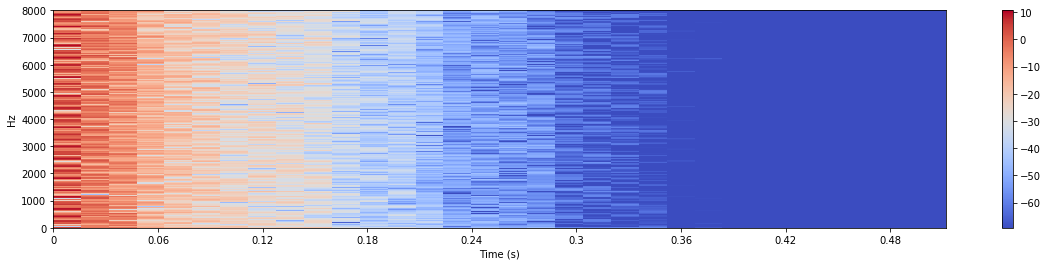

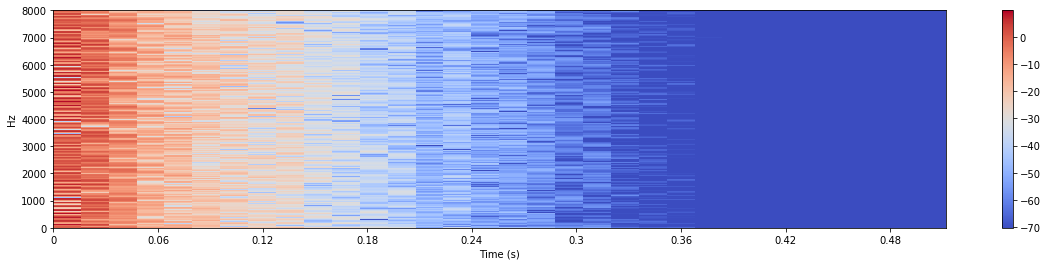

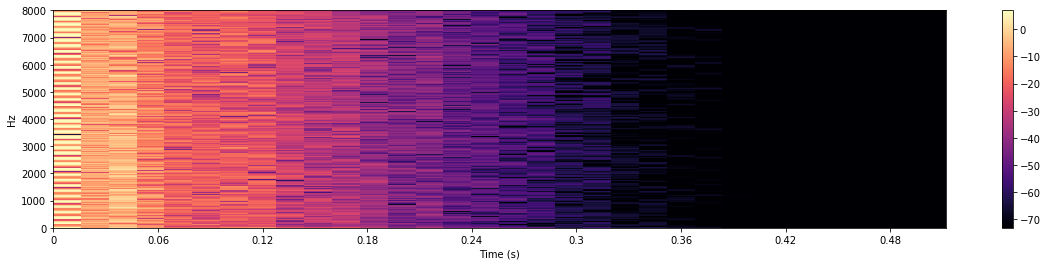

In [40]:
#example

rt60 = 500 #500
edt = 50 #50
itdg = 3 #3
er_duration = 80 #80
drr = int(rt60 * (-1 /100)) + np.random.randint(0, np.ceil(rt60 * (1 / 100)))
sr = 16000

"""
Energetic stochastic impulse response.
Args:
    rt60: reverberation time [ms]
    edt: early decay time [ms]
    itdg: initial time delay gap [ms]
    er_duration: early reflections duration [ms]
    drr: direct to reverberant energy ratio [dB]
"""
    

rir = ImpulseResponse(rt60=rt60,
                     edt=edt,
                     itdg=itdg,
                     drr=drr,
                     er_duration=er_duration)

# get n impulse responses
n=5
for i in range(n):
    
    output = rir.generate(sampling_rate=sr)
    #draw_spectrogram(output)
    sf.write(str(i) + '_ir_ex.wav', output, 16000)
    
    print(output.shape)

# Convolving
만들어진 RIR과 오디오 파일을 convolving하면 우리가 가지고 있는 데이터셋에 적용할 수 있습니다.
예를 들어 복도의 RIR 파일을 내 목소리 파일과 convolving하면 마치 내 목소리가 복도에서 녹음된 것과 같은 효과를 낼 수 있습니다.

In [24]:
# convolving
# https://github.com/josephernest/impulseresponse.py

import numpy as np
from wave import open # wave.py 파일로부터 open 이라는 함수를 불러옵니다.
import soundfile
import librosa
import os
import soundfile as sf
import random

class Wave:
    def __init__(self, data, frame_rate):
        self.data = normalize(data)
        self.frame_rate = frame_rate

    def make_spectrum(self):
        amplitudes = np.fft.rfft(self.data)
        frequencies = np.fft.rfftfreq(len(self.data), 1 / self.frame_rate)

        return Spectrum(amplitudes, frequencies, self.frame_rate)

    def zero_padding(self, n):
        zeros = np.zeros(n)
        zeros[:len(self.data)] = self.data

        self.data = zeros

    def write(self, file):
        reader = open(file, 'w')

        reader.setnchannels(1)
        reader.setsampwidth(2)
        reader.setframerate(self.frame_rate)

        frames = self.quantize().tostring()
        reader.writeframes(frames)

        reader.close()

    def quantize(self):
        if max(self.data) > 1 or min(self.data) < -1:
            self.data = normalize(self.data)

        return (self.data * 32767).astype(np.int16)


class Spectrum:
    def __init__(self, amplitudes, frequencies, frame_rate):
        self.amplitudes = np.asanyarray(amplitudes)
        self.frequencies = np.asanyarray(frequencies)
        self.frame_rate = frame_rate

    def __mul__(self, other):
        return Spectrum(self.amplitudes * other.amplitudes, self.frequencies, self.frame_rate)

    def make_wave(self):
        return Wave(np.fft.irfft(self.amplitudes), self.frame_rate)


def convert_wav(file):
    data, samprate = soundfile.read(file)
    soundfile.write(file, data, samprate, subtype='PCM_16')
    #soundfile.write(file, data, samprate)

def read_wave(file):
    reader = open(file)

    _, sampwidth, framerate, nframes, _, _ = reader.getparams()
    frames = reader.readframes(nframes)

    reader.close()

    dtypes = {1: np.int8, 2: np.int16, 4: np.int32}

    if sampwidth not in dtypes:
        raise ValueError('unsupported sample width')

    data = np.frombuffer(frames, dtype=dtypes[sampwidth])

    num_channels = reader.getnchannels()
    if num_channels == 2:
        data = data[::2]

    return Wave(data, framerate)


def normalize(data):
    high, low = abs(max(data)), abs(min(data))
    return data / max(high, low)


def convolution_reverb(audio_file, ir_file, output_file):
    convert_wav(audio_file)
    convert_wav(ir_file)

    audio = read_wave(audio_file)
    ir = read_wave(ir_file)
    
    if len(audio.data) > len(ir.data):
        ir.zero_padding(len(audio.data))

    else:
        audio.zero_padding(len(ir.data))

    ir_spectrum = ir.make_spectrum()
    audio_spectrum = audio.make_spectrum()

    convolution = audio_spectrum * ir_spectrum
    wave = convolution.make_wave()
    wave.write(output_file)
    
    


In [ ]:
#convolution_reverb('audio.wav', 'ir.wav', 'result.wav')